<a href="https://colab.research.google.com/github/haozhez4/CS441-Final_Project/blob/main/441final_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
pip install imbalanced-learn

In [35]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

EPSILON = 1e-6

# ==========================
# 0. Utility functions
# ==========================
def signed_log1p(x: pd.Series) -> pd.Series:
    """Signed log transform: sign(x) * log(1 + |x|)"""
    return np.sign(x) * np.log1p(np.abs(x))

def safe_log_ratio(a, b, eps=1e-6):
    """Numerically stable log(a / b)"""
    ratio = (a + eps) / (b + eps)
    ratio = np.clip(ratio, eps, None)
    return np.log(ratio)

def make_daily_portfolio_topk(df_slice, prob, k=5, fee_per_day=0.0):
    """
    Top-K equal-weight portfolio backtest:
    - Each day, select the K stocks with the highest predicted probability
    - Daily return = average realized return of the selected stocks
    - Subtract a fixed transaction fee per day
    """
    tmp = df_slice[["time", "ret_1d_real"]].copy()
    tmp["p"] = prob

    tmp = tmp.sort_values(["time", "p"], ascending=[True, False])
    tmp["rank"] = tmp.groupby("time").cumcount()
    pick = tmp[tmp["rank"] < k]

    daily_ret = pick.groupby("time")["ret_1d_real"].mean().sort_index()

    # Ensure every trading day exists in the return series
    all_days = np.sort(tmp["time"].unique())
    daily_ret = daily_ret.reindex(all_days, fill_value=0.0)

    # Apply transaction cost on days with positions
    held_days = pick.groupby("time").size().reindex(all_days, fill_value=0) > 0
    daily_ret.loc[held_days] = daily_ret.loc[held_days] - fee_per_day

    equity = (1.0 + daily_ret).cumprod()
    return daily_ret, equity

# ==========================
# 1. Load and preprocess data
# ==========================
path = "/content/drive/My Drive/hs300_clean_data.csv"
df = pd.read_csv(path)

df["time"] = pd.to_datetime(df["time"])
df = df.sort_values(["code", "time"]).reset_index(drop=True)

# Ensure optional columns exist
for col in ["money", "netamount_main", "netamount_xl"]:
    if col not in df.columns:
        df[col] = 0.0

g = df.groupby("code")

# ==========================
# 2. Label construction
# ==========================
# Label = 1 if next-day return > 0.5%, otherwise 0
# Optionally drop samples with small absolute returns
RET_THR = 0.005      # 0.5% threshold
DROP_NEUTRAL = True  # Drop samples with |return| <= threshold

next_close = g["close"].shift(-1)
ret_1d_real = (next_close - df["close"]) / (df["close"] + EPSILON)

df["ret_1d_real"] = np.where(next_close.notna(), ret_1d_real, np.nan)
df["label"] = np.where(next_close.notna(), (ret_1d_real > RET_THR).astype(int), np.nan)

if DROP_NEUTRAL:
    df["keep"] = np.where(next_close.notna(), (np.abs(ret_1d_real) > RET_THR), False)
else:
    df["keep"] = np.where(next_close.notna(), True, False)

# ==========================
# 3. Feature construction (r1 ~ r46)
# ==========================
# Price-based features (r1 ~ r16)
df["r1"]  = safe_log_ratio(g["close"].shift(0), g["close"].shift(1))
df["r2"]  = safe_log_ratio(g["close"].shift(1), g["close"].shift(2))
df["r3"]  = safe_log_ratio(g["close"].shift(2), g["close"].shift(3))
df["r4"]  = safe_log_ratio(g["close"].shift(3), g["close"].shift(4))
df["r5"]  = safe_log_ratio(g["close"].shift(0), g["open"].shift(0))
df["r6"]  = safe_log_ratio(g["close"].shift(1), g["open"].shift(1))
df["r7"]  = safe_log_ratio(g["close"].shift(2), g["open"].shift(2))
df["r8"]  = safe_log_ratio(g["close"].shift(3), g["open"].shift(3))
df["r9"]  = safe_log_ratio(g["high"].shift(1),  g["open"].shift(1))
df["r10"] = safe_log_ratio(g["high"].shift(2),  g["open"].shift(2))
df["r11"] = safe_log_ratio(g["high"].shift(3),  g["open"].shift(3))
df["r12"] = safe_log_ratio(g["high"].shift(0),  g["open"].shift(0))
df["r13"] = safe_log_ratio(g["low"].shift(0),   g["open"].shift(0))
df["r14"] = safe_log_ratio(g["low"].shift(1),   g["open"].shift(1))
df["r15"] = safe_log_ratio(g["low"].shift(2),   g["open"].shift(2))
df["r16"] = safe_log_ratio(g["low"].shift(3),   g["open"].shift(3))

# Money flow features (r17 ~ r20)
df["r17"] = safe_log_ratio(g["money"].shift(0), g["money"].shift(1))
df["r18"] = safe_log_ratio(g["money"].shift(1), g["money"].shift(2))
df["r19"] = safe_log_ratio(g["money"].shift(2), g["money"].shift(3))
df["r20"] = safe_log_ratio(g["money"].shift(3), g["money"].shift(4))

# Main capital flow features (r21 ~ r23)
main0 = signed_log1p(g["netamount_main"].shift(0))
main1 = signed_log1p(g["netamount_main"].shift(1))
main2 = signed_log1p(g["netamount_main"].shift(2))
main3 = signed_log1p(g["netamount_main"].shift(3))
df["r21"] = main0 - main1
df["r22"] = main0 - main2
df["r23"] = main0 - main3

# Extra-large order flow features (r24 ~ r26)
xl0 = signed_log1p(g["netamount_xl"].shift(0))
xl1 = signed_log1p(g["netamount_xl"].shift(1))
xl2 = signed_log1p(g["netamount_xl"].shift(2))
xl3 = signed_log1p(g["netamount_xl"].shift(3))
df["r24"] = xl0 - xl1
df["r25"] = xl0 - xl2
df["r26"] = xl0 - xl3

# Moving average features (r27 ~ r29)
df["MA5"]  = g["close"].transform(lambda x: x.rolling(5).mean())
df["MA10"] = g["close"].transform(lambda x: x.rolling(10).mean())
df["r27"] = safe_log_ratio(df["close"], df["MA5"])
df["r28"] = safe_log_ratio(df["close"], df["MA10"])
df["r29"] = safe_log_ratio(df["MA5"], df["MA10"])
df = df.drop(columns=["MA5", "MA10"], errors="ignore")

# RSI feature (r30)
delta = g["close"].diff()
gain = delta.clip(lower=0)
loss = (-delta).clip(lower=0)
window_rsi = 14
avg_gain = gain.groupby(df["code"]).rolling(window_rsi).mean().reset_index(level=0, drop=True)
avg_loss = loss.groupby(df["code"]).rolling(window_rsi).mean().reset_index(level=0, drop=True)
RS = avg_gain / (avg_loss + EPSILON)
df["r30"] = 100 - (100 / (1 + RS))

# MACD feature (r31)
df["EMA12"] = g["close"].transform(lambda x: x.ewm(span=12, adjust=False).mean())
df["EMA26"] = g["close"].transform(lambda x: x.ewm(span=26, adjust=False).mean())
df["r31"] = safe_log_ratio(df["EMA12"], df["EMA26"])
df = df.drop(columns=["EMA12", "EMA26"], errors="ignore")

# Bollinger Band feature (r32)
df["MB20"]  = g["close"].transform(lambda x: x.rolling(20).mean())
df["STD20"] = g["close"].transform(lambda x: x.rolling(20).std())
df["r32"] = (df["close"] - df["MB20"]) / (df["STD20"] + EPSILON)
df = df.drop(columns=["MB20", "STD20"], errors="ignore")

# ATR feature (r33)
df["prev_close"] = g["close"].shift(1)
tr1 = df["high"] - df["low"]
tr2 = (df["high"] - df["prev_close"]).abs()
tr3 = (df["low"] - df["prev_close"]).abs()
df["TR_temp"] = np.maximum.reduce([tr1, tr2, tr3])
window_atr = 14
df["ATR"] = df["TR_temp"].groupby(df["code"]).transform(lambda x: x.rolling(window_atr).mean())
df["r33"] = df["ATR"] / (df["close"] + EPSILON)
df = df.drop(columns=["ATR", "TR_temp", "prev_close"], errors="ignore")

# Momentum feature (r34)
momentum_window = 10
df["r34"] = safe_log_ratio(g["close"].shift(0), g["close"].shift(momentum_window))

# Volatility-related features (r35 ~ r36)
df["prev_close"] = g["close"].shift(1)
tr1_new = df["high"] - df["low"]
tr2_new = (df["high"] - df["prev_close"]).abs()
tr3_new = (df["low"] - df["prev_close"]).abs()
df["r35"] = np.maximum.reduce([tr1_new, tr2_new, tr3_new])
window_atr_new = 14
df["r36"] = df["r35"].groupby(df["code"]).transform(lambda x: x.rolling(window_atr_new).mean())
df = df.drop(columns=["prev_close"], errors="ignore")

# Trend-related features (r37 ~ r40)
window_trend = 20
df["r37"] = g["close"].transform(lambda x: x.ewm(span=window_trend, adjust=False).mean())

wma_half = g["close"].transform(lambda x: x.ewm(span=window_trend//2, adjust=False).mean())
wma_full = g["close"].transform(lambda x: x.ewm(span=window_trend, adjust=False).mean())
wma_diff = 2 * wma_half - wma_full
df["r38"] = wma_diff.groupby(df["code"]).transform(lambda x: x.ewm(span=int(np.sqrt(window_trend)), adjust=False).mean())

df["EMA9_MACD_temp"] = df["r31"].groupby(df["code"]).transform(lambda x: x.ewm(span=9, adjust=False).mean())
df["r39"] = safe_log_ratio(df["r31"], df["EMA9_MACD_temp"])
df = df.drop(columns=["EMA9_MACD_temp"], errors="ignore")

# ADX feature (r40)
window_adx = 14
high_diff = df.groupby("code")["high"].diff()
low_diff  = df.groupby("code")["low"].diff()

plus_dm = pd.Series(np.where((high_diff > low_diff) & (high_diff > 0), high_diff, 0.0), index=df.index)
minus_dm = pd.Series(np.where((low_diff > high_diff) & (low_diff > 0), low_diff, 0.0), index=df.index)

smooth_plus_dm  = plus_dm.groupby(df["code"]).transform(lambda x: x.ewm(span=window_adx, adjust=False).mean())
smooth_minus_dm = minus_dm.groupby(df["code"]).transform(lambda x: x.ewm(span=window_adx, adjust=False).mean())
smooth_tr       = df["r35"].groupby(df["code"]).transform(lambda x: x.ewm(span=window_adx, adjust=False).mean())

plus_di  = 100 * (smooth_plus_dm / (smooth_tr + EPSILON))
minus_di = 100 * (smooth_minus_dm / (smooth_tr + EPSILON))
dx = 100 * (np.abs(plus_di - minus_di) / (plus_di + minus_di + EPSILON))
df["r40"] = dx.groupby(df["code"]).transform(lambda x: x.ewm(span=window_adx, adjust=False).mean())

# Oscillator features (r41 ~ r44)
window_osc = 14
df["TP"] = (df["high"] + df["low"] + df["close"]) / 3
df["SM"] = df["TP"].groupby(df["code"]).transform(lambda x: x.rolling(window_osc).mean())
df["MD"] = df["TP"].groupby(df["code"]).transform(
    lambda x: x.rolling(window_osc).apply(lambda z: np.abs(z - z.mean()).mean(), raw=True)
)
df["r41"] = (df["TP"] - df["SM"]) / (0.015 * df["MD"] + EPSILON)
df = df.drop(columns=["TP", "SM", "MD"], errors="ignore")

high_n = df["high"].groupby(df["code"]).transform(lambda x: x.rolling(window_osc).max())
low_n  = df["low"].groupby(df["code"]).transform(lambda x: x.rolling(window_osc).min())
df["r42"] = -100 * (high_n - df["close"]) / (high_n - low_n + EPSILON)
df["r43"] = 100 * (df["close"] - low_n) / (high_n - low_n + EPSILON)

window_slow = 3
df["r44"] = df["r43"].groupby(df["code"]).transform(lambda x: x.rolling(window_slow).mean())

# Cross-indicator features (r45, r46)
df["MA20_temp"] = df["close"].groupby(df["code"]).transform(lambda x: x.rolling(window_trend).mean())
df["r45"] = safe_log_ratio(df["MA20_temp"], df["r37"])
df = df.drop(columns=["MA20_temp"], errors="ignore")

df["r46"] = safe_log_ratio(df["close"], df["r38"])

# Clean feature matrix
r_cols = [f"r{i}" for i in range(1, 47)]
df[r_cols] = df[r_cols].replace([np.inf, -np.inf], np.nan).fillna(0.0)

# ==========================
# 4. Build final dataset (X, y, time)
# ==========================
valid = df[df["keep"]].dropna(subset=["label", "ret_1d_real"]).copy()

X = valid[r_cols].to_numpy()
y = valid["label"].astype(int).to_numpy()
t = valid["time"].to_numpy()

print("X shape:", X.shape)
print("y shape:", y.shape)
print(f"Positive ratio: {y.mean():.3f}")

# ==========================
# 5. Time-based split (70 / 15 / 15)
# ==========================
q1 = np.quantile(t, 0.7)
q2 = np.quantile(t, 0.85)

train_mask = t < q1
val_mask   = (t >= q1) & (t < q2)
test_mask  = t >= q2

X_train, y_train = X[train_mask], y[train_mask]
X_val,   y_val   = X[val_mask],   y[val_mask]
X_test,  y_test  = X[test_mask],  y[test_mask]

print("Train:", X_train.shape[0])
print("Val:",   X_val.shape[0])
print("Test:",  X_test.shape[0])

# ==========================
# 6. Train MLP (no data leakage)
# ==========================
CUSTOM_PARAMS = {
    "hidden_layer_sizes": (128, 64),
    "alpha": 0.0001,
    "learning_rate_init": 0.001,
    "max_iter": 1000,
}

mlp = MLPClassifier(
    hidden_layer_sizes=CUSTOM_PARAMS["hidden_layer_sizes"],
    activation="relu",
    solver="adam",
    learning_rate="adaptive",
    learning_rate_init=CUSTOM_PARAMS["learning_rate_init"],
    alpha=CUSTOM_PARAMS["alpha"],
    batch_size=256,
    max_iter=CUSTOM_PARAMS["max_iter"],
    early_stopping=True,
    validation_fraction=0.10,
    shuffle=False,
    random_state=42,
    verbose=False,
)

model = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", mlp),
])

print("\n==================================")
print(f"Training MLP on TRAIN only ({X_train.shape[0]} samples)")
print("==================================")
model.fit(X_train, y_train)

# ==========================
# 7. Classification evaluation
# ==========================
print("\n====== Validation (default predict) ======")
y_val_pred = model.predict(X_val)
print("Val Acc:", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred, digits=4))

print("\n====== Test (default predict) ======")
y_test_pred = model.predict(X_test)
print("Test Acc:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred, digits=4))

# ==========================
# 8. Top-K backtest on test set
# ==========================
p_test = model.predict_proba(X_test)[:, 1]
test_df = valid.loc[test_mask, ["time", "ret_1d_real"]].copy()

FEE_PER_DAY = 0.0005

print("\n==================================")
print("Daily Portfolio Backtest (TEST, Top-K)")
print("==================================")

for TOPK in [5, 10, 20]:
    daily_ret_k, equity_k = make_daily_portfolio_topk(
        df_slice=test_df,
        prob=p_test,
        k=TOPK,
        fee_per_day=FEE_PER_DAY
    )
    print(f"Top-{TOPK} | Days={len(daily_ret_k)} "
          f"| Avg daily ret={float(daily_ret_k.mean()):.6f} "
          f"| Win days={float((daily_ret_k>0).mean()):.4f} "
          f"| Final equity={float(equity_k.iloc[-1]):.6f}")


X shape: (152241, 46)
y shape: (152241,)
Positive ratio: 0.475
Train: 106410
Val: 22918
Test: 22913

Training MLP on TRAIN only (106410 samples)

====== Validation (default predict) ======
Val Acc: 0.50279256479623
              precision    recall  f1-score   support

           0     0.5184    0.7049    0.5974     11995
           1     0.4643    0.2809    0.3500     10923

    accuracy                         0.5028     22918
   macro avg     0.4913    0.4929    0.4737     22918
weighted avg     0.4926    0.5028    0.4795     22918


====== Test (default predict) ======
Test Acc: 0.501200192030725
              precision    recall  f1-score   support

           0     0.5009    0.7337    0.5953     11458
           1     0.5021    0.2686    0.3500     11455

    accuracy                         0.5012     22913
   macro avg     0.5015    0.5012    0.4727     22913
weighted avg     0.5015    0.5012    0.4727     22913


Daily Portfolio Backtest (TEST, Top-K)
Top-5 | Days=109 | Avg da

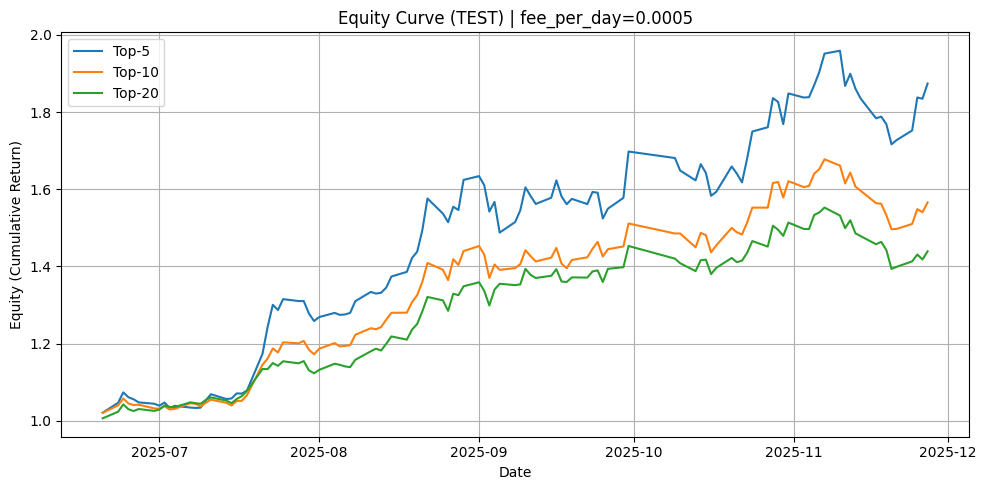

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

for TOPK in [5, 10, 20]:
    daily_ret_k, equity_k = make_daily_portfolio_topk(
        df_slice=test_df,
        prob=p_test,
        k=TOPK,
        fee_per_day=FEE_PER_DAY
    )
    plt.plot(equity_k.index, equity_k.values, label=f"Top-{TOPK}")

plt.title(f"Equity Curve (TEST) | fee_per_day={FEE_PER_DAY}")
plt.xlabel("Date")
plt.ylabel("Equity (Cumulative Return)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

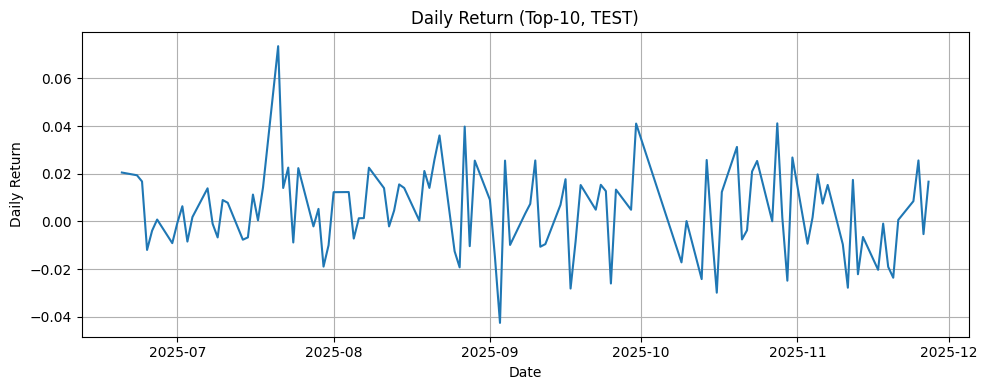

In [39]:
daily_ret_10, equity_10 = make_daily_portfolio_topk(test_df, p_test, k=10, fee_per_day=FEE_PER_DAY)

plt.figure(figsize=(10, 4))
plt.plot(daily_ret_10.index, daily_ret_10.values)
plt.title("Daily Return (Top-10, TEST)")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.grid(True)
plt.tight_layout()
plt.show()